In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os

In [20]:
DIR_FACE = "/content/drive/My Drive/face_detector"
MASK_MODEL = "/content/drive/My Drive/Mask_Detector_model.model"

In [21]:
def detect_and_predict_mask(frame, faceNet, maskNet):
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
                                 (104.0, 177.0, 123.0))

    faceNet.setInput(blob)
    detections = faceNet.forward()


    faces = []
    locs = []
    preds = []

    for i in range(0, detections.shape[2]):

        confidence = detections[0, 0, i, 2]


        if confidence > 0.7:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

            faces.append(face)
            locs.append((startX, startY, endX, endY))

    if len(faces) > 0:
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)

    return (locs, preds)

In [22]:
print("loading face detector model...")
prototxtPath = os.path.sep.join([DIR_FACE, "deploy.prototxt"])
weightsPath = os.path.sep.join([DIR_FACE, "res10_300x300_ssd_iter_140000.caffemodel"])

faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

print("loading face mask detector model...")
maskNet = load_model(MASK_MODEL)

loading face detector model...
loading face mask detector model...


In [36]:
from matplotlib import pyplot as plt
import numpy as np

def detect_mask(Input_Image_Path,Output_Image_Path):
  # load the input image from disk, clone it, and grab the image spatial
  # dimensions
  image = cv2.imread(Input_Image_Path)
  orig = image.copy()
  (h, w) = image.shape[:2]
  # construct a blob from the image
  blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
    (104.0, 177.0, 123.0))
  # pass the blob through the network and obtain the face detections
  print("[INFO] computing face detections...")
  faceNet.setInput(blob)
  detections = faceNet.forward()
  # loop over the detections
  for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with
    # the detection
    confidence = detections[0, 0, i, 2]
    # filter out weak detections by ensuring the confidence is
    # greater than the minimum confidence
    if confidence > 0.5:
      # compute the (x, y)-coordinates of the bounding box for
      # the object
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")
      # ensure the bounding boxes fall within the dimensions of
      # the frame
      (startX, startY) = (max(0, startX), max(0, startY))
      (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
      # extract the face ROI, convert it from BGR to RGB channel
      # ordering, resize it to 224x224, and preprocess it
      face = image[startY:endY, startX:endX]
      face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
      face = cv2.resize(face, (224, 224))
      face = img_to_array(face)
      face = preprocess_input(face)
      face = np.expand_dims(face, axis=0)
      # pass the face through the model to determine if the face
      # has a mask or not
      (withoutMask, mask) = maskNet.predict(face)[0]
      # determine the class label and color we'll use to draw
      # the bounding box and text
      if mask > withoutMask:
        label = "Safe"
        color = (0, 255, 0)
      else:
        label = "Not Safe"
        color = (0, 0, 255)
      # include the probability in the label
      label = "{}: {:.2f}%".format(label, max(withoutMask, mask) * 100)
      # display the label and bounding box rectangle on the output
      # frame
      cv2.putText(image, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
  # show the output image
  cv2.imwrite(Output_Image_Path, image)
  print("done")
  image2 = image[:,:,::-1]
  plt.figure(figsize = (15,15))
  plt.imshow(image2, aspect='auto')


[INFO] computing face detections...
done


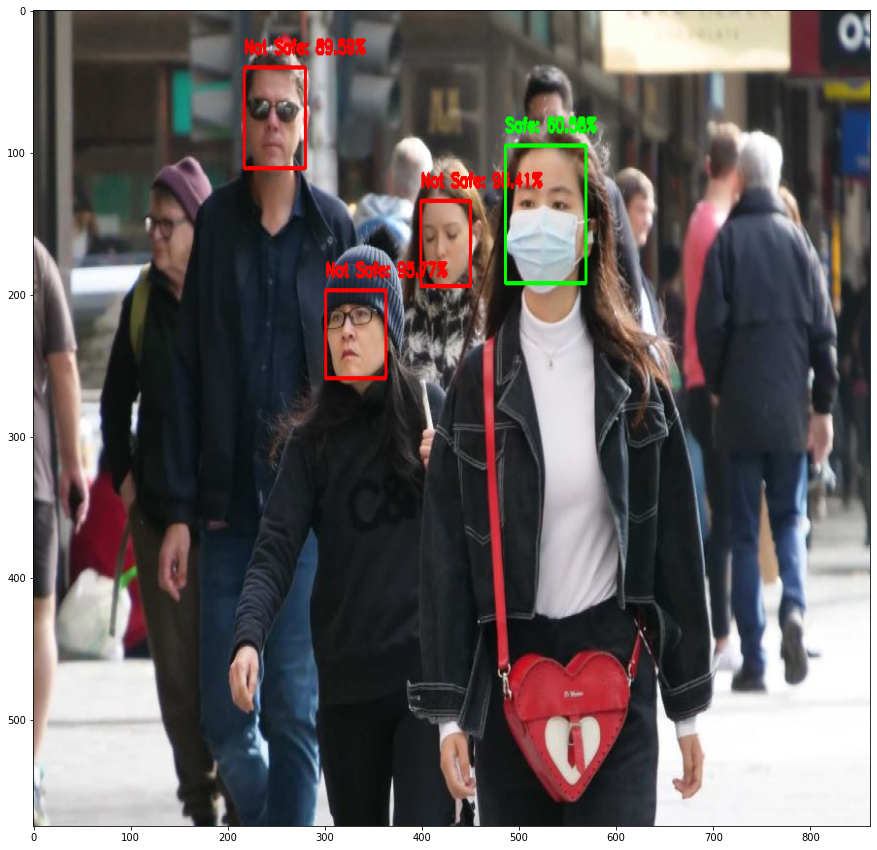

In [40]:
Input_Image_Path = "/content/drive/My Drive/Sample Images/input1.jpg"
Output_Image_Path = "/content/drive/My Drive/output1.jpg"

detect_mask(Input_Image_Path,Output_Image_Path)

[INFO] computing face detections...
done


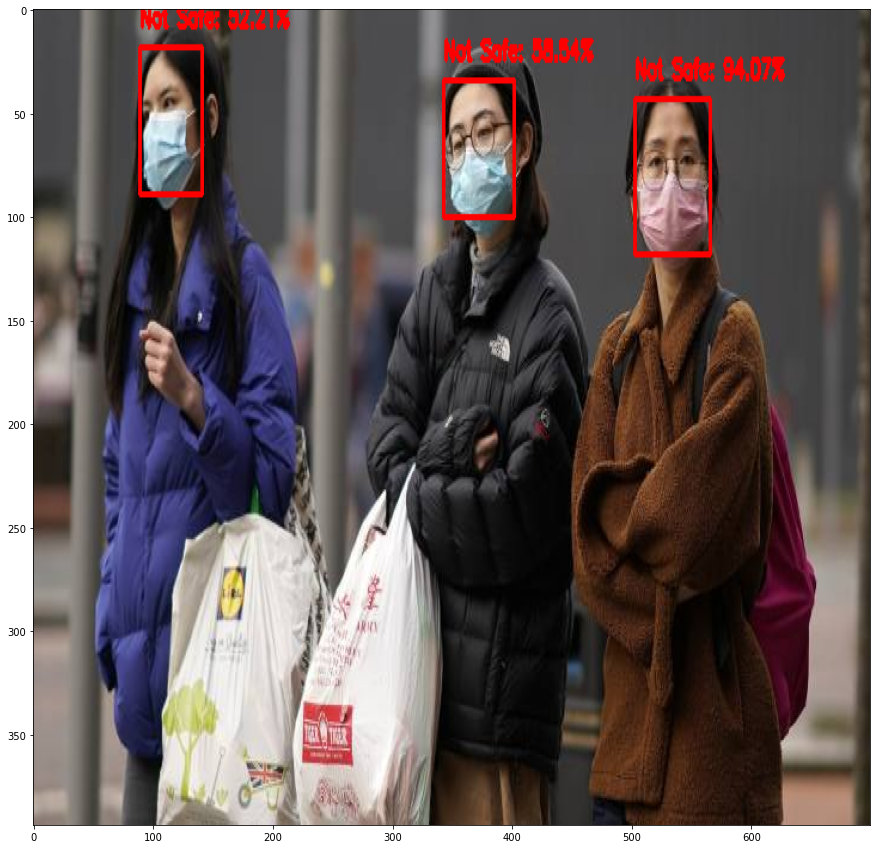

In [39]:
Input_Image_Path = "/content/drive/My Drive/Sample Images/input2.jpg"
Output_Image_Path = "/content/drive/My Drive/output2.jpg"

detect_mask(Input_Image_Path,Output_Image_Path)